# Finding Bayesian Legos - Part 2

## Saving feet one model at a time

![Legos on the floor](https://github.com/hankroark/finding-bayesian-legos/raw/master/images/partIIimage.jpg)
Photo by [Markus Spiske on Unsplash](https://unsplash.com/photos/C0koz3G1I4I)

[Last time on Finding Bayesian Legos](https://towardsdatascience.com/https-medium-com-hankroark-finding-bayesian-legos-part1-b8aeb886afba), my dear friend Joe and I were trying to find a way to help Joe gain confidence that he has indeed picked-up all of the Legos® his children left behind.  My first proposal was that we determine how good Joe is at picking up Legos by performing experiments on Joe to determine the probability he would pick a single Lego in any given sweep of the room where the Legos have been left laying.  Joes said, "No go on this plan!  I really dislike picking up Legos.  Can't you find a better way?"

> "Tell me more about how you go about picking up after your kids."  

Joe explains to me that he usually picks up the Legos after his children are tucked away in bed.  Joe likes to unwind with a little reading or television each night.  In between chapters of the book, or during television commercials, he will make a quick sweep picking up the Legos.  The first sweep seems to get most of the Legos, with each pass picking up part of what was missed from the prior sweep.  He keeps doing this until he calls it a night and heads of to bed.

> "Joe, I think we can work with this."

I ask Joe to do a minor bit of work next time he picks up Legos.  I ask him to count how many he picks up in each pass and record it.  He reluctantly agrees, but anything to help him gain confidence that he will not step on Legos when he gets up the next morning and heads to the coffee maker.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

np.random.seed(42)  # It's nice to replicate even virtual experiments

In [2]:
import pymc3 as pm
import scipy.stats as stats
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


## Hidden Section - Generating data
This section of cells hidden in the Medium article because we don't know how good Joe is at picking up Legos.

In [3]:
# Generate data until all the Legos are really picked up

np.random.seed(75)
alpha = 30
beta = 10 
mean_actual_prob = alpha / (alpha + beta)

mean_legos_left = 200
N_remaining = np.random.poisson(mean_legos_left, size=1)
actual_prob = np.empty(0, dtype=np.float32)
N_removed_until_zero = np.zeros(0, dtype=np.int16)

while N_remaining[-1] > 0:
    actual_prob = np.append( actual_prob, np.random.beta(a=alpha, b=beta) * 0.9**len(actual_prob) )
    N_removed_until_zero = np.append( N_removed_until_zero, np.random.binomial(N_remaining[-1], actual_prob[-1]) )
    N_remaining = np.append( N_remaining, N_remaining[-1] - N_removed_until_zero[-1] )


In [4]:
# Quick look remaining after index i passes.  N_remaining[0] is the total number actually left by Joe's child.
N_remaining

array([203,  68,  20,   9,   5,   2,   2,   1,   1,   1,   0])

In [5]:
# The number removed in each pass iff Joe had kept going until there really were zero Lego's remaining
N_removed_until_zero

array([135,  48,  11,   4,   3,   0,   1,   0,   0,   1])

In [6]:
# The number Joe reports picking up after each pass.  He stops after a pass reveals zero Legos remaining.
Removed = N_removed_until_zero[:(N_removed_until_zero==0).argmax(axis=0)+1]
Removed = np.append( 0, Removed )
Removed

array([  0, 135,  48,  11,   4,   3,   0])

## Joe reports back

A few days later I get an email from Joe: he has done as asked.  Joe reports that he made six sweeps with the following number of Legos being picked up in each sweep:

In [7]:
Removed[1:]

array([135,  48,  11,   4,   3,   0])

I invite Joe over for dinner and some Bayesian analysis that evening.

## Dinner with PyMC

After finishing up our dinner of kale, avocado, and black bean burrito bowls, Joe and I cozy around the big screen for the analysis.

I explain to Joe that each time he makes a sweep of the room, it's like every Lego has some probability of being picked up.  We don't know how many Legos there really are and that is what we are trying to determine, with probabilities.  Joe can then compare this to the total number he has picked up to see if he wants to make another pass.  Because I've had a few days to work this out, I sketch up the model and then go back and explain it:

$$ 
\begin{align}
p \sim \textrm{Beta}(\alpha, \beta) \\
R_{i+1} \sim \textrm{Bin}(N_i - R_i, p) \\
R_0 = 0 \\
i \in [0, n]
\end{align}
$$

In this case, *p&#8203;* indicates that probability that Joe will pick up a single Lego.  The probability *p&#8203;* is modeled as a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) (in part 1 we covered why we used a Beta distribution).  The number of Legos remaining is *N_i*, after *i&#8203;* sweeps by Joe to pick up Legos; Joe makes a total of *n&#8203;* sweeps.  For each sweep *i&#8203;* Joe removed *R_i* Legos.  What we are trying to determine is *N₀*, the number of Legos originally left behind by Joe's offspring.  *R₀* being set to zero handles the boundary condition where Joe picks up zero Legos on the zeroth sweep.

To complete the model, we need some prior distributions for *N₀*, *α&#8203;*, *β&#8203;*. As in the first episode, we pick parameters such that the distributions prior to modeling are weakly informative:

$$
\begin{align}
\alpha \sim \textrm{Cauchy}^+( \beta = 2 ) \\
\beta \sim \textrm{Cauchy}^+( \beta = 2 ) \\
N_0 \sim \textrm{Unif}(0, N_{max}), N_{max} = 3000
\end{align}
$$

The parameters for the prior probability distribution is the same as in the first episode.  I ask Joe for the absolute maximum Legos he things his kid might leave behind.  Joe estimates around two-thousand, so I make the maximum, *N_max* three-thousand to be on the safe side, and use a uniform distribution of prior probabilities between 0 and *N_max* inclusive to model the initial number of Legos left behind.

Now all that remains is to make the model in PyMC and review the results to see if they might help Joe.

### Model setup and fitting

The transfer from the model into PyMC code is a really direct translation and fitting with the default No-U-Turn sampler.  After some fidgeting around, the number of tuning samples was increased over the default and the target acceptance rate is set a bit higher than normal; this is done to deal with some of the problematic posteriors in this problem.  Nicely, the PyMC library does a good job helping users tune these parameters by doing model fitting checks and highlighting likely problematic issues.

I want Joe to have an approximation of how many Legos are remaining after each time he does a sweep.  This will help Joe make a better decision of when he wants to stop because I know just how very much Joe wants to decrease the amount of energy he puts into Lego gathering.  With that, we will start with the minimal information, just the number removed in the first sweep.  Also, a deterministic calculation of the estimated number of remaining Legos is included, mostly to make it easy for Joe to decide how many Legos might be remaining.  Even though *n_remaining_est* is deterministic, it is a random variable because the two input variables to *n_remaining_est* are random variables.

In [8]:
sweep_model = pm.Model()

with sweep_model:
    n_0_est = pm.DiscreteUniform('n_0_est', lower=0, upper=3000)
    alpha_sweep = pm.HalfCauchy('alpha_sweep', beta = 2.)  
    beta_sweep = pm.HalfCauchy('beta_sweep', beta = 2.)    
    
    p_sweep = pm.Beta('p_sweep', alpha=alpha_sweep, beta=beta_sweep)
    removed_sweep_1 = pm.Binomial('removed_sweep_1', p=p_sweep, 
                                   n=n_0_est, observed=Removed[1]  )
    n_remaining_est = pm.Deterministic('n_remaining_est', n_0_est - removed_sweep_1)

In [9]:
with sweep_model:
    trace = pm.sample(50000, tune=7500, random_seed=123, progressbar=True, nuts_kwargs={"target_accept":0.95})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [n_0_est]
>NUTS: [p_sweep, beta_sweep, alpha_sweep]
Sampling 2 chains: 100%|██████████| 115000/115000 [04:09<00:00, 460.83draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Model evaluation

After completing the model fitting, Joe and I take a quick look at the trace plots.  We are focused on the initial number of Legos and the estimated number remaining after the first sweep.

Unfortunately, after just one sweep there is not much narrowing down of the number of remaining Legos compared to before the sweep.  This makes sense from mathematical intuition:  there are two parameters to estimate, the probability of picking up a Lego and the initial number of Legos, but only one known variable, the number of Legos picked up in the first pass.  It is, at best, difficult to solve for two unknown variables with only one known equation.

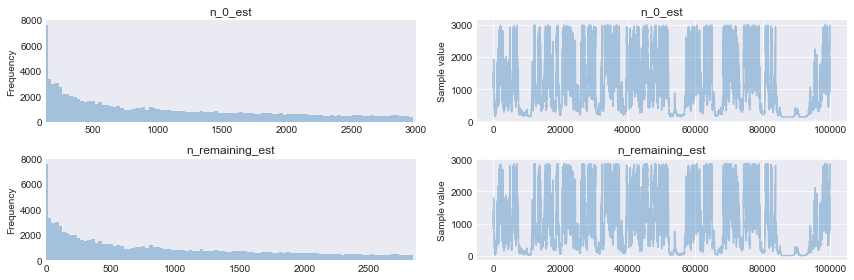

In [10]:
pm.traceplot(trace, varnames=['n_0_est', 'n_remaining_est'], combined=True);

In [11]:
pm.summary(trace, varnames=['n_0_est', 'n_remaining_est']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0_est,1075.88,824.85,61.02,135.0,2685.0,60.18,1.02
n_remaining_est,940.88,824.85,61.02,0.0,2550.0,60.18,1.02


### Second sweep

At this point, Joe's not sure if the work has been worth the effort.  I encourage Joe that we should continue, for his feet if nothing else.  We soldier on an create a model based on the first and second observed sweep data Joe provided.  The model creation code is starting to look a little repetitive, but for the sake of quick experimentation, I do some 'copy-paste' of code and run the model, thinking if it works I'll refactor it later.

In this model, we take the estimated number of Legos remaining after sweep one subtracted from the estimated initial number of Legos, and use that as the input for the number of Legos remaining for the second sweep.  We are modeling repeated, sequential binomial trials.

In [12]:
sweep_model = pm.Model()

with sweep_model:
    n_0_est = pm.DiscreteUniform('n_0_est', lower=0, upper=3000)
    alpha_sweep = pm.HalfCauchy('alpha_sweep', beta = 2.)  
    beta_sweep = pm.HalfCauchy('beta_sweep', beta = 2.)    
    p_sweep = pm.Beta('p_sweep', alpha=alpha_sweep, beta=beta_sweep)
    removed_sweep_1 = pm.Binomial('removed_sweep_1', p=p_sweep, 
                                  n=n_0_est, observed=Removed[1] )
    n_1_est = n_0_est - removed_sweep_1
    removed_sweep_2 = pm.Binomial('removed_sweep_2', p=p_sweep, 
                                   n=n_1_est, observed=Removed[2] )
    n_remaining_est = pm.Deterministic('n_remaining_est', n_0_est - removed_sweep_1 - removed_sweep_2)

In [13]:
with sweep_model:
    trace = pm.sample(50000, tuning=7500, random_seed=123, progressbar=True,
                     nuts_kwargs={"target_accept":0.95})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [n_0_est]
>NUTS: [p_sweep, beta_sweep, alpha_sweep]
Sampling 2 chains: 100%|██████████| 101000/101000 [03:53<00:00, 431.64draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


> "Joe, we are getting somewhere now."

A quick look at the model results and we see that the range of estimated Lego's remaining has been narrowed to between 9 and 62 with 95% confidence.  At this point, Joe is getting encouraged that counting all of those Legos might have been worth it.  He wants to keep going, but I have some other plans.

It's getting a bit late, and I decide it is time to refactor this code.  Joe heads home for the night and we promise to get together tomorrow.  With a bit cleaner code I hope to be able to move much faster.

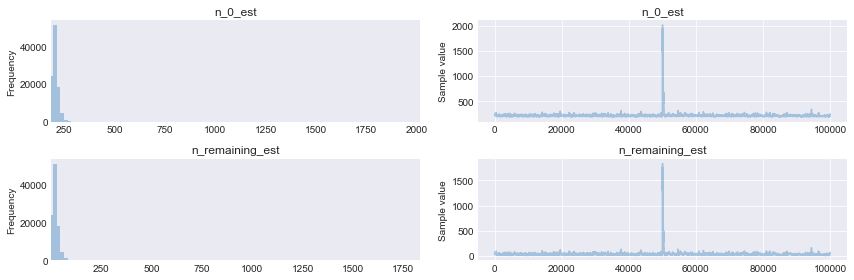

In [14]:
pm.traceplot(trace, varnames=['n_0_est', 'n_remaining_est'], combined=True);

In [15]:
pm.summary(trace, varnames=['n_0_est', 'n_remaining_est']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0_est,217.82,66.53,3.94,192.0,245.0,275.01,1.0
n_remaining_est,34.82,66.53,3.94,9.0,62.0,275.01,1.0


## Cleaner code through math

Joe comes by the following evening with takeaway in hand.  I grab my laptop and share with Joe what has transpired overnight.

> "This is really a multinomial problem."

[Multinomial distributions](https://en.wikipedia.org/wiki/Multinomial_distribution) model the count that some event out of *k&#8203;* possible events happens some number of times *n&#8203;*.  It is a generalization of the binomial distribution.  Think of throwing a 6-sided die repeatedly (6 possible events, 1 through 6, one for each side of the die) and counting how many times it lands with each side up.  The multinomial model allows for each event to have different probabilities of happening.  Continuing with the 6-side die analogy, that would like if the die somehow had different probabilities of each side landing upwards.  That is the process the multinomial distribution models.  Joe looks at me a little puzzled, so I go on.

In our scenario, each Lego lands in one of the *n&#8203;* sweeps **or** has yet to be picked up.  Each sweep, plus the event of not being picked up, is like one side of the die.  The probability of a Lego getting picked up in the first sweep is unknown and modeled as *p&#8203;*. The probability of a Lego getting picked up in the second sweep is the probability of the Lego **not** being picked up in the first sweep **and** the probability of it getting picked up in the second sweep.  The probability of a Lego remaining is just whatever probability remains after summing up all the probabilities of a Lego getting picked across all the sweeps.

$$
\begin{align}
  \mathbf{R} \sim \textrm{Multinomial}(N_0, p_1 ... p_n\, p_{remains}) \\
  p_i = p \cdot (1-p)^{i-1} \\
  p_{remains} = 1 - \sum_{i} p_i \\
  \textrm{for}\, i \in [1,n_{sweeps}]
\end{align}
$$

Here **R&#8203;** is a vector of the count for each of the probabilities given (that is, it is the estimated number of Legos picked up in each sweep), *N₀* is the number of trials (or in our case, the estimate of the number of Legos initially left laying), *p_i* is the probability of a Lego being picked up in sweep *i&#8203;*, *p_remains* is the probability of a Lego not being picked up, and *n_sweeps* is the total number of sweeps performed.

While [PyMC3 has a multinomial distribution](https://docs.pymc.io/api/distributions/multivariate.html#pymc3.distributions.multivariate.Multinomial) it does not have this kind of "incomplete Multinomial distribution", where the size of the multinomial population is unknown and to be estimated. There have been several papers on this subject of estimating the multinomial population size from the observed draws; my favorite is [by Sanathanan](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177692709).  I'm heck bent on taking a Bayesian approach and using PyMC3.  After a bit of experimenting, I determine the workable solution is to generalize the repeated binomial approach tried earlier.  I wrote up a function to encapsulate the model of removal, calling the new model a `RemovalMultinomial`.  While I'm sure there are better ways to do this, Joe and I are pretty ready to get this done.

In [16]:
# Done quickly to make code a bit easier to deal with
# Doesn't do much / any error checking of the inputs, assumes observed information
def RemovalMultinomial(basename, n, p, observed):
    remaining = n
    results = []
    for idx, p_idx in enumerate(p):
        i = idx+1
        name = basename + '_{}'.format(i)
        removed = pm.Binomial(name, n=remaining, p=p_idx, observed=observed[idx])
        results.append(removed)
        remaining = remaining - removed
    remaining = pm.Deterministic( basename+'_remaining', remaining)
    results.append(remaining)
    return results

With this new function, the setup for the model is much shorter, parameterized just by the number of sweeps.  We will do the model with 3 sweeps, one more than last time.  This helps Joe and I know how much information we are getting sweep to sweep.  Also, it might help Joe determine when he can stop 'early' in his passes based on his own model of risk of having a density of Legos remaining on the floor, poised to cause him pain if he were to step on them.  Right now Joe keeps doing sweeps for Legos until he makes a pass and doesn't see any Legos to pick up.

In [17]:
n_sweeps = 3

sweep_model = pm.Model()

with sweep_model:
    n_0_est = pm.DiscreteUniform('n_0_est', lower=0, upper=3000)
    alpha_sweep = pm.HalfCauchy('alpha_sweep', beta = 2.)  # Weakly regularizing prior
    beta_sweep = pm.HalfCauchy('beta_sweep', beta = 2.)    # Weakly regularizing prior
    p_sweep = pm.Beta('p_sweep', alpha=alpha_sweep, beta=beta_sweep)
    
    p_multinomial = [ pm.Deterministic('p_{}'.format(str(i+1)), p_sweep) for i in range(0,n_sweeps) ]
                                   
    removed = RemovalMultinomial('rr', n=n_0_est, p=p_multinomial, observed=Removed[1:] )

In [18]:
with sweep_model:
    trace = pm.sample(50000, tuning=7500, random_seed=123, progressbar=True,
                     nuts_kwargs={"target_accept":0.95})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [n_0_est]
>NUTS: [p_sweep, beta_sweep, alpha_sweep]
Sampling 2 chains: 100%|██████████| 101000/101000 [04:07<00:00, 408.50draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


> "This is looking pretty good!", says Joe

Joe and I are getting pretty excited.  With this last round, after three sweeps of picking up Legos, there is now a 95% confidence interval that there are between zero (!) and thirteen Legos remaining.  Joe is pretty happy with these results and feels like it can help him determine if he wants to continue making passes or call it a night.

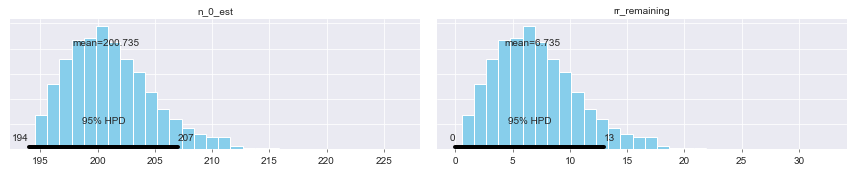

In [19]:
pm.plot_posterior(trace, varnames=['n_0_est', 'rr_remaining']);

In [20]:
pm.summary(trace, varnames=['n_0_est', 'rr_remaining']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0_est,200.74,3.66,0.08,194.0,207.0,1806.39,1.0
rr_remaining,6.74,3.66,0.08,0.0,13.0,1806.39,1.0


## One final model

In this last model, we want to test how good Joe's current heuristic is for stopping.  Joe typically stops looking for Legos when he makes a pass and he finds no more Legos to pick up.  Now that we have maths behind us we can quantify, at least in based on these results and the assumptions of the model, the quality of the stopping strategy employed by Joe.  We create a model of all six passes Joes performed and use that to estimate the number of Legos remaining.

In [21]:
# Not included in Medium for space
n_sweeps = len( Removed[1:] )

sweep_model = pm.Model()

with sweep_model:
    n_0_est = pm.DiscreteUniform('n_0_est', lower=0, upper=3000)
    alpha_sweep = pm.HalfCauchy('alpha_sweep', beta = 2.)  # Weakly regularizing prior
    beta_sweep = pm.HalfCauchy('beta_sweep', beta = 2.)    # Weakly regularizing prior
    p_sweep = pm.Beta('p_sweep', alpha=alpha_sweep, beta=beta_sweep)
    p_multinomial = [ pm.Deterministic('p_{}'.format(str(i+1)), p_sweep) for i in range(0,n_sweeps) ]                           
    removed = RemovalMultinomial('rr', n=n_0_est, p=p_multinomial, observed=Removed[1:] )
    trace = pm.sample(50000, tuning=7500, random_seed=123, progressbar=True,
                     nuts_kwargs={"target_accept":0.95})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [n_0_est]
>NUTS: [p_sweep, beta_sweep, alpha_sweep]
Sampling 2 chains: 100%|██████████| 101000/101000 [04:26<00:00, 378.52draws/s]
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.17501474601649594, but should be close to 0.95. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


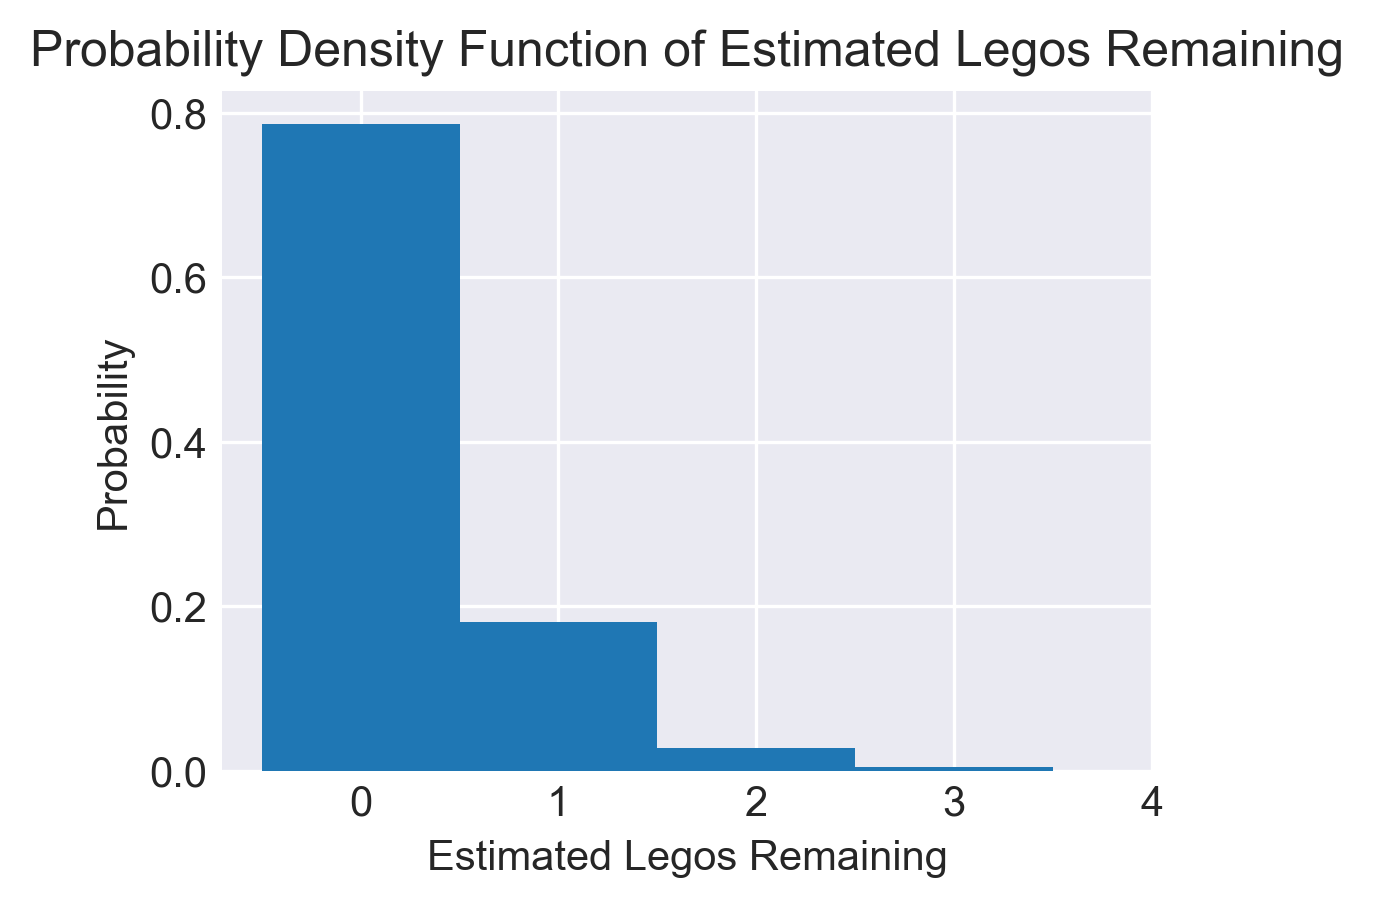

In [22]:
plt.figure(figsize=(4,3), dpi=300)
plt.hist(trace['rr_remaining'], density=True, bins=range(0,5), align='left')
plt.xlabel('Estimated Legos Remaining')
plt.xticks(range(0,5))
plt.ylabel('Probability')
plt.title('Probability Density Function of Estimated Legos Remaining')
plt.grid(True)
plt.show();

## Some models are useful

At this point, Joe and I are pretty happy with the model results.  It looks like, at least in this example, there is about a one-in-five (20%) chance that there is at least one Lego remaining.  Joe says he can take this and use it if I'll clean it up and stick it in a mobile app.  Joe is a very funny person!  I agree to check this code into GitHub and show Joe how to use it.

All is good, Joe goes home.  And then the call comes, "Hank, I'm still *finding* Legos the day after, and a lot more a lot more often than I think the model predicts."